In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv
/kaggle/input/celeba-dataset/list_eval_partition.csv
/kaggle/input/celeba-dataset/list_attr_celeba.csv
/kaggle/input/celeba-dataset/list_bbox_celeba.csv


In [ ]:
!pip install transformers==4.40.1 datasets==2.19.0 --no-deps -q


In [ ]:
!pip install tokenizers==0.19.1 --quiet
!pip install sentence-transformers==2.2.2 --quiet


In [12]:
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset
import torch

# Load local TSV files
train_df = pd.read_csv("/kaggle/input/sst-2-data/train.tsv", sep="\t")
val_df = pd.read_csv("/kaggle/input/sst-2-data/test.tsv", sep="\t")
test_df = pd.read_csv("/kaggle/input/sst-2-data/dev.tsv", sep="\t", header=None, names=["index", "sentence"])  # Test has no labels

train_df.head(20)



,1,"a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films"
0,0,apparently reassembled from the cutting-room f...
1,0,they presume their audience wo n't sit still f...
2,1,this is a visually stunning rumination on love...
3,1,jonathan parker 's bartleby should have been t...
4,1,campanella gets the tone just right -- funny i...
5,0,a fan film that for the uninitiated plays bett...
6,1,"béart and berling are both superb , while hupp..."
7,0,"a little less extreme than in the past , with ..."
8,0,the film is strictly routine .
9,1,a lyrical metaphor for cultural and personal s...


In [13]:
import pandas as pd

# Read and fix TSV files
train_df = pd.read_csv("/kaggle/input/sst-2-data/train.tsv", sep="\t", header=None, names=["label","sentence"])
val_df   = pd.read_csv("/kaggle/input/sst-2-data/test.tsv", sep="\t", header=None, names=["label","sentence"])
test_df  = pd.read_csv("/kaggle/input/sst-2-data/dev.tsv", sep="\t", header=None, names=["index","sentence"])

# Drop rows with missing sentences
for df in [train_df, val_df, test_df]:
    df.dropna(subset=["sentence"], inplace=True)
    df["sentence"] = df["sentence"].astype(str).str.strip()  # Make sure all are strings


In [14]:
print("Train columns:", train_df.columns)
print("Val columns:", val_df.columns)
print("Test columns:", test_df.columns)


Train columns: Index(['label', 'sentence'], dtype='object')
Val columns: Index(['label', 'sentence'], dtype='object')
Test columns: Index(['index', 'sentence'], dtype='object')


In [15]:
print(train_df["sentence"].head())
print(train_df["sentence"].apply(type).value_counts())


0    a stirring , funny and finally transporting re...
1    apparently reassembled from the cutting-room f...
2    they presume their audience wo n't sit still f...
3    this is a visually stunning rumination on love...
4    jonathan parker 's bartleby should have been t...
Name: sentence, dtype: object
sentence
<class 'str'>    6920
Name: count, dtype: int64


In [16]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
# Custom Dataset class
class SST2Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128, is_test=False):
        self.encodings = tokenizer(
            list(df["sentence"]),  # ✅ force list of clean strings
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        if not is_test:
            self.labels = torch.tensor(df["label"].tolist())
        else:
            self.labels = None
        self.is_test = is_test

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if not self.is_test:
            item["label"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Create datasets
train_dataset = SST2Dataset(train_df, tokenizer)
val_dataset = SST2Dataset(val_df, tokenizer)
test_dataset = SST2Dataset(test_df, tokenizer, is_test=True)


In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [19]:
from transformers import BertForSequenceClassification, AdamW
import torch
from tqdm import tqdm

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(2):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())
# Save fine-tuned model weights
torch.save(model.state_dict(), "bert_finetuned_sst2.pth")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 2: 100%|██████████| 433/433 [01:23<00:00,  5.20it/s, loss=0.0608]


In [20]:
from transformers import BertForSequenceClassification

# Load your trained classifier
finetuned_model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
finetuned_model.load_state_dict(torch.load("bert_finetuned_sst2.pth"))  # 👈 your actual fine-tuned model
bert_model = finetuned_model.bert  # Extract encoder part
bert_model.to(device)
bert_model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [21]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
from tqdm import tqdm

# Use your cleaned validation data
texts = val_df["sentence"].tolist()[:200]

# Load pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

def extract_cls_embeddings(texts, model, tokenizer, batch_size=32):
    all_embeddings = []
    model.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting CLS embeddings"):
        batch_texts = texts[i:i+batch_size]  # ✅ define batch_texts correctly

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=128
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}  # move to device

        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.concatenate(all_embeddings, axis=0)



In [22]:

# Call the function
embeddings_before = extract_cls_embeddings(texts, bert_model, tokenizer)


Extracting CLS embeddings: 100%|██████████| 7/7 [00:00<00:00, 18.51it/s]


In [23]:
embeddings_after = extract_cls_embeddings(texts, bert_model, tokenizer)
print("✅ Embeddings After Fine-Tuning Shape:", embeddings_after.shape)


Extracting CLS embeddings: 100%|██████████| 7/7 [00:00<00:00, 19.25it/s]

✅ Embeddings After Fine-Tuning Shape: (200, 768)


In [24]:
print("Sample BEFORE embedding:\n", embeddings_before[0][:10])
print("Sample AFTER embedding:\n", embeddings_after[0][:10])


Sample BEFORE embedding:
 [-0.48133302 -0.0061969  -0.5747665  -0.10401071 -0.74675167 -0.30365008
  0.25604016  1.0778906  -0.16725217 -0.14872774]
Sample AFTER embedding:
 [-0.48133302 -0.0061969  -0.5747665  -0.10401071 -0.74675167 -0.30365008
  0.25604016  1.0778906  -0.16725217 -0.14872774]


In [9]:
!pip install umap-learn -q


In [10]:
import umap
import numpy as np

# Combine before and after embeddings
combined = np.concatenate([embeddings_before, embeddings_after], axis=0)

# Apply UMAP (you can use n_neighbors=15 for more local structure)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(combined)


2025-06-19 05:08:43.673055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750309723.712570     224 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750309723.726655     224 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


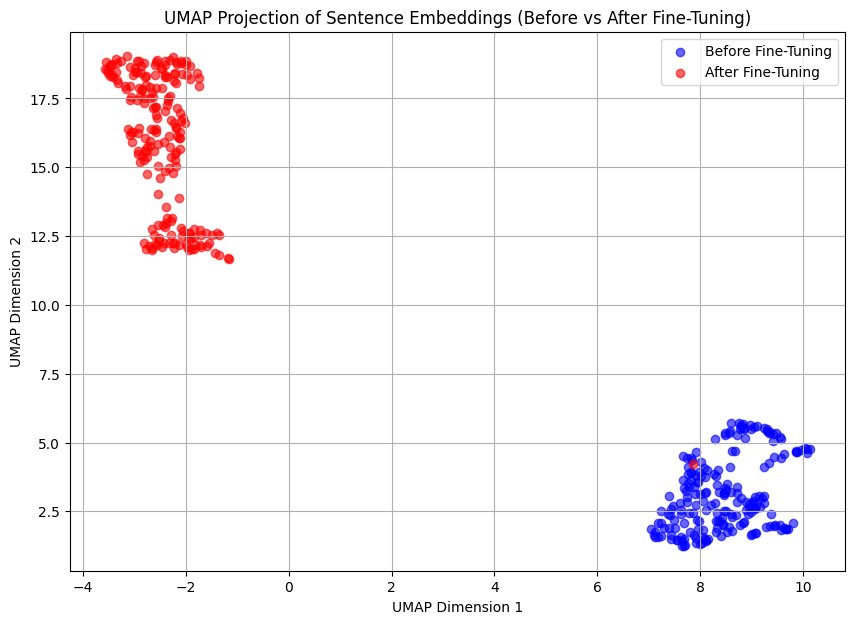

In [11]:
import matplotlib.pyplot as plt

# First 200 = before, next 200 = after
before_2d = embedding_2d[:200]
after_2d = embedding_2d[200:]

plt.figure(figsize=(10, 7))
plt.scatter(before_2d[:, 0], before_2d[:, 1], label="Before Fine-Tuning", alpha=0.6, color="blue")
plt.scatter(after_2d[:, 0], after_2d[:, 1], label="After Fine-Tuning", alpha=0.6, color="red")
plt.legend()
plt.title("UMAP Projection of Sentence Embeddings (Before vs After Fine-Tuning)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings_before, embeddings_after)

# Optional: print average drift
avg_cos_drift = 1 - np.diag(cos_sim_matrix).mean()
print(f"Average Cosine Drift: {avg_cos_drift:.4f}")


Average Cosine Drift: 0.6933
